# Textual Inversion

This method consists of introducing a new keyword (like dreambooth) to the language model to influence the output images. Different from dreambooth which finetune the unet to introduce completely a new object, texture inversion finetune only the text encoder to be able to introduce a new cencept, which allows to blend the new concept to image generator.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [378]:
!nvidia-smi

Mon Dec  2 15:32:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:08:00.0 Off |                  N/A |
| 32%   31C    P8             23W /  420W |    5803MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## play with prompt

### How embedding works

In [2]:
# Tokenization converts language units (word, syllable...) into a numerical representation.
# By using transformers tokensizers, it will return a dict of 2 items: 
# - input_ids: the numerical representation of the input text
# - attention_mask: mask used for the transformer bloc

# take a sample text
text = "a picture of cat."

# load tokenizer
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")

# tokenize the text
tokens = tokenizer(text, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")

# look at the tokens
tokens

{'input_ids': tensor([[49406,   320,  1674,   539,  2368,   269, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [3]:
tokens["input_ids"].device

device(type='cpu')

In [4]:
# the correspondings

translation = {t: tokenizer.decode(t) for t in tokens["input_ids"][0][:7]}
translation

{tensor(49406): '<|startoftext|>',
 tensor(320): 'a',
 tensor(1674): 'picture',
 tensor(539): 'of',
 tensor(2368): 'cat',
 tensor(269): '.',
 tensor(49407): '<|endoftext|>'}

In [ ]:
# embed the tokens

# load text encoder
from transformers import CLIPTextModel
encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder").to(device)

# show the encoder's components
print(encoder.text_model)

# embed tokens
embeddings = encoder(tokens["input_ids"].to(encoder.device))

# show the embeds
embeddings.last_hidden_state

CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 768)
    (position_embedding): Embedding(77, 768)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm): L

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.8184, -0.3705,  0.1845,  ..., -0.3553,  0.6024, -0.8507],
         [-0.8063, -0.3766,  0.1956,  ..., -0.3457,  0.6007, -0.8451],
         [-0.8521, -0.3208,  0.2432,  ..., -0.3334,  0.5961, -0.8672]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [56]:
encoder.text_model.embeddings.position_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76]], device='cuda:0')

In [6]:
# there are 2 embedding model inside the embedding bloc.
# the token_embedding enbeds the actual tokens, which has learnable parameters
# the final embedding is the sum of the 2 embeddings.

# we can use it to encode whatever the token
another_embed = encoder.text_model.embeddings.token_embedding(torch.tensor([2368], device=encoder.device))
another_embed.shape

torch.Size([1, 768])

In [ ]:
# get the final output of the encoder from the embeddings (token embeds + position embeds)

def build_causal_attention_mask(bsz, seq_len, dtype=torch.float32):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    mask = torch.empty((bsz, seq_len, seq_len), dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask

def embeds2outputs(embeds):
    # get mask
    print(embeds.shape, type(embeds.shape[0]))
    mask = build_causal_attention_mask(1, 77).to(device)

    # get the final output
    outputs = encoder.text_model.encoder(
        inputs_embeds=embeds,
        attention_mask=None,
        causal_attention_mask=mask,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None)
    
    outputs = encoder.text_model.final_layer_norm(outputs[0])

    return outputs

In [39]:
from tqdm.notebook import tqdm
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# generate with embeddings
def generate_emebds(embeds):
    
    num_inference_steps = 40
    guidance_scale = 7
    generator = torch.manual_seed(34)
    batch_size = 1

    uncond = tokenizer([""] * batch_size, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")

    with torch.no_grad():
        uncond_embeds = encoder(uncond["input_ids"].to(encoder.device))[0]

    text_embeds = torch.cat([uncond_embeds, embeds])

    scheduler.set_timesteps(num_inference_steps)

    # get latents
    latents = torch.randn((batch_size, 4, 64, 64), generator=generator).to(device)
    latents = latents * scheduler.init_noise_sigma

    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        latent_extend = torch.cat([latents]*2)
        latent_extend = scheduler.scale_model_input(latent_extend, t)

        with torch.no_grad():
            noise_pred = unet(latent_extend, t, encoder_hidden_states=text_embeds).sample

        # guidance
        noise_uncond, noise_text = noise_pred.chunk(2)
        noise_pred = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    return latents

In [27]:
# convert latents to image
from diffusers import AutoencoderKL
import PIL.Image as Image

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [10]:
word = "bird"

# tokenize
tokens_word = tokenizer(word)

tokens_word


{'input_ids': [49406, 3329, 49407], 'attention_mask': [1, 1, 1]}

In [49]:
cat_emebeds = encoder.text_model.embeddings.token_embedding(torch.tensor(2368, device=encoder.device))
bird_embeds = encoder.text_model.embeddings.token_embedding(torch.tensor(3329, device=encoder.device))

print(cat_emebeds.shape)

mixed_ratio = 0.5
mixed_embeds = (1.0 - mixed_ratio) * cat_emebeds + mixed_ratio * bird_embeds

print(mixed_embeds.shape, mixed_embeds.device)

# remplace
embeds_original = encoder.text_model.embeddings.token_embedding(tokens["input_ids"].to(encoder.device))
print(embeds_original.shape, embeds_original.device)

embeds_original[0, torch.where(tokens["input_ids"][0]==2368)] = mixed_embeds
print(embeds_original[0, torch.where(tokens["input_ids"]==2368)])

position_ids = encoder.text_model.embeddings.position_ids[:, :77]

pos_embeds = encoder.text_model.embeddings.position_embedding(position_ids)

embeds_total = embeds_original + pos_embeds

print(embeds_total.shape, embeds_total.device)

encode_output = embeds2outputs(embeds_total)

print(encode_output.shape)

output_latents = generate_emebds(encode_output)

torch.Size([768])
torch.Size([768]) cuda:0
torch.Size([1, 77, 768]) cuda:0
tensor([[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
        [ 0.0119, -0.0089, -0.0134,  ...,  0.0030, -0.0017, -0.0097]],
       device='cuda:0', grad_fn=<IndexBackward0>)
torch.Size([1, 77, 768]) cuda:0
torch.Size([1, 77, 768]) <class 'int'>
test1  cpu
torch.Size([1, 1, 77, 77]) tensor([[[[ 0.0000e+00, -3.4028e+38, -3.4028e+38,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
      

  0%|          | 0/40 [00:00<?, ?it/s]

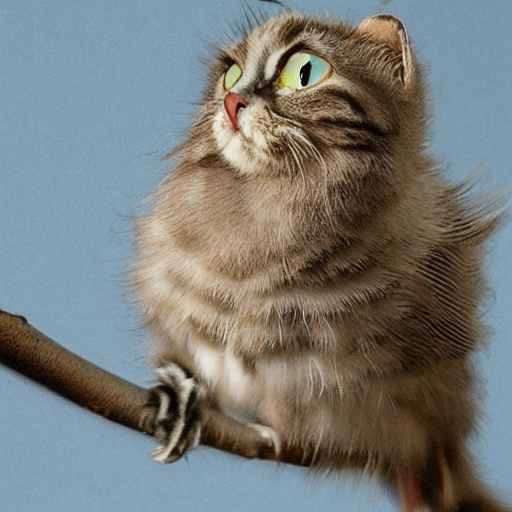

In [50]:
latents_to_pil(output_latents)[0]

# Textual Inversion

It consists of fine-tuning a specialized object with its specialized lable, which can then be mixed later with other words (in the same manner as before) to create new images.
https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb#scrollTo=bctHoiRPoWlY

## Fine-Tuning

#### load images

In [284]:
# load dataset
import datasets, glob

img_dict = {"image": []}

for file in glob.glob('./tmp/abstract-style/*'):
    print(file)
    img_dict["image"].append(file)
print(img_dict)

dataset = datasets.Dataset.from_dict(img_dict).cast_column("image", datasets.Image())
dataset


./tmp/abstract-style/360_F_544821358_BIRKeQA6UVuO9aNypdmb4ZFQJYOCHyv3.jpg
./tmp/abstract-style/cubist2.png
./tmp/abstract-style/cubist3.png
./tmp/abstract-style/cubist4.png
./tmp/abstract-style/Untitled.png
{'image': ['./tmp/abstract-style/360_F_544821358_BIRKeQA6UVuO9aNypdmb4ZFQJYOCHyv3.jpg', './tmp/abstract-style/cubist2.png', './tmp/abstract-style/cubist3.png', './tmp/abstract-style/cubist4.png', './tmp/abstract-style/Untitled.png']}


Dataset({
    features: ['image'],
    num_rows: 5
})

In [ ]:
# my png images return 4 channels

dataset[2]["image"].getbands()

('R', 'G', 'B', 'A')

#### input texts for training

In [392]:
# the texts to play with
placeholder = "<abcube-style>"
initializer = "abstract"

# input texts
imagenet_object_templates = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

#### torch dataset

In [393]:
# define dataset

from torch.utils.data import Dataset
from torchvision import transforms
import random

class TIDataset(Dataset):

    def __init__(self, ds, tokenizer, place_holder, learn_feature="object", size=512):
        self.ds = ds
        self.tokenizer = tokenizer
        self.size = size
        self.place_holder = place_holder
        self.learn_texts = imagenet_style_templates if learn_feature == "style" else imagenet_object_templates
        self.transforms = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, ind):
        samples = {}

        # get image
        img = self.ds[ind]["image"].convert("RGB")
        samples["image"] = self.transforms(img)

        # get tokens
        text = random.choice(self.learn_texts).format(self.place_holder)
        tokens = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True)

        samples["input_ids"] = tokens["input_ids"][0]

        return samples
 

In [394]:
# construct dataset

import torch.utils.data.dataloader

myds= TIDataset(dataset, tokenizer, placeholder, learn_feature="style")

#### placeholder

In [ ]:
# add new placeholder token to the text model

# load tokenizer
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")

# add new placeholder to the tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder)
if num_added_tokens == 0: #
    raise ValueError(
        f"The tokenizer already contains the token {placeholder}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

# tokenize placeholder
else:
    token = tokenizer.convert_tokens_to_ids(placeholder)
    print(f"Added {num_added_tokens} new tokens to the tokenizer as {token}.")
    placeholder_token = token

# tokenize intializer
intializer_token = tokenizer.encode(initializer, add_special_tokens=False)
if len(intializer_token) > 1:
    raise ValueError("The initializer token must be a single token.")

intializer_token = intializer_token[0]

print("initializer token:", intializer_token, "; placeholder token:", placeholder_token)


# notes
# tokenizer's vocab_size won't change after "add_tokens" since this is 
# a fixed attributes (https://github.com/huggingface/transformers/blob/2dd9440d0835782e41ae415a68e71fd15051c428/src/transformers/tokenization_utils.py#L161)
# To get the new vocab size, use "len(tokenizer)"

Added 1 new tokens to the tokenizer as 49408.
initializer token: 10197 ; placeholder token: 49408


In [406]:
# load SD model components

ckp = "CompVis/stable-diffusion-v1-4"

clip_encoder = CLIPTextModel.from_pretrained(ckp, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(ckp, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(ckp, subfolder="unet")


In [407]:
# be defautl, the clip encoder gas token_embedding component works with
# dimension (49408, 768) of which 49408 is the dict dimension of tokenizer
# before adding the placeholder.
print("vocab size: ", clip_encoder.config.vocab_size)
print("token embedding dim: ", clip_encoder.text_model.embeddings.token_embedding)

# After adding the placeholder, we have to resize the token_embedding component
# take care of the new token.

clip_encoder.resize_token_embeddings(len(tokenizer))
print("vocab size: ", clip_encoder.config.vocab_size)
print("token embedding dim: ", clip_encoder.text_model.embeddings.token_embedding)


vocab size:  49408
token embedding dim:  Embedding(49408, 768)
vocab size:  49409
token embedding dim:  Embedding(49409, 768)


In [134]:
for p in clip_encoder.get_input_embeddings().parameters():
    print(p.shape)

torch.Size([49409, 768])


#### train loop

In [408]:
import itertools

def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    clip_encoder.text_model.encoder.parameters(),
    clip_encoder.text_model.final_layer_norm.parameters(),
    clip_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [410]:
from argparse import Namespace

args = Namespace( 
    lr = 5e-4,
    batch_size = 8,
    dataset = myds,
    max_train_steps = 2000,
    save_steps = 200,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    seed = 42,
    output_dir = "./tmp/outputs"
)

In [411]:
# loop

from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, StableDiffusionPipeline
import math, os
import torch.nn.functional as F

def train(encoder:CLIPTextModel, vae, unet):

    # config accelerator
    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps)

    # set generator seed
    set_seed(args.seed)

    # define schduler
    scheduler = DDPMScheduler.from_config(ckp, subfolder="scheduler")

    # get dataloader
    dataloader = torch.utils.data.DataLoader(args.dataset, batch_size=args.batch_size, shuffle=True)

    # set checkpointing
    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # define optimizer
    optim= torch.optim.AdamW(encoder.get_input_embeddings().parameters(), lr=args.lr)

    # wrap to accelerator
    encoder, optim, dataloader = accelerator.prepare(encoder, optim, dataloader)

    # set training precision - use half
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # convert models
    vae = vae.to(accelerator.device, dtype=weight_dtype)
    unet = unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    # recalculate the steps
    num_steps_update_per_epoch = math.ceil(len(dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_steps_update_per_epoch)

    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)

    global_steps = 0

    for epoch in range(num_train_epochs):

        encoder.train()

        for step, batch in enumerate(dataloader):

            with accelerator.accumulate(encoder):

                # print("test1:", batch["image"].shape)

                # encode image to latents
                with torch.no_grad():
                    latents = vae.encode(batch["image"].to(dtype=weight_dtype)).latent_dist.sample().detach() * 0.18215

                # sample noise
                z = torch.randn_like(latents).to(latents.device)

                # sample time steps
                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (z.shape[0],), device=latents.device)

                # add noise
                noisy_latents = scheduler.add_noise(latents, z, timesteps)

                # encode prompt
                encoded_prompt = encoder(batch["input_ids"])[0]

                # predict noise
                preds = unet(noisy_latents, timesteps, encoder_hidden_states=encoded_prompt).sample


                # Get the target for loss depending on the prediction type
                if scheduler.config.prediction_type == "epsilon":
                    target = z
                elif scheduler.config.prediction_type == "v_prediction":
                    target = scheduler.get_velocity(latents, z, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

                loss = F.mse_loss(preds, z, reduction="none").mean([1,2,3]).mean()

                # back prop
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = encoder.get_input_embeddings().weight.grad

                # get the index of the placeholder
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                # step optimizer
                optim.step()
                optim.zero_grad()

            # update progress bar
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_steps += 1
                if global_steps % args.save_steps == 0:
                    save_path = os.path.join(args.output_dir, "textinversion", f"step-{global_steps}.bin")
                    accelerator.save_state(save_path)
                    print(f"Saved checkpoint at step {global_steps}")
            
            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_steps >= args.max_train_steps:
                break
        accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        pipe = StableDiffusionPipeline.from_pretrained(
            ckp,
            text_encoder=accelerator.unwrap_model(encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet
        )
        save_path = os.path.join(args.output_dir, "textinversion")
        pipe.save_pretrained(save_path)
        


In [412]:
# train
from accelerate import notebook_launcher
num_of_gpus = 1 
notebook_launcher(
    train, args=(clip_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.


/home/Qingyi/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/2000 [00:00<?, ?it/s]

Saved checkpoint at step 200
Saved checkpoint at step 400
Saved checkpoint at step 600
Saved checkpoint at step 800
Saved checkpoint at step 1000
Saved checkpoint at step 1200
Saved checkpoint at step 1400
Saved checkpoint at step 1600
Saved checkpoint at step 1800
Saved checkpoint at step 2000


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [413]:
# free memory
import itertools

for param in itertools.chain(unet.parameters(), clip_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

## inference

In [414]:
# load pipeline
pipe = StableDiffusionPipeline.from_pretrained(os.path.join(args.output_dir, "textinversion")).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [415]:

new_prompt = f"a picture of cat in the style of {placeholder}"
print(new_prompt)


images = pipe([new_prompt] * 8, num_inference_steps=30, guidance_scale=7.5).images
len(images)

a picture of cat in the style of <abcube-style>


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


8

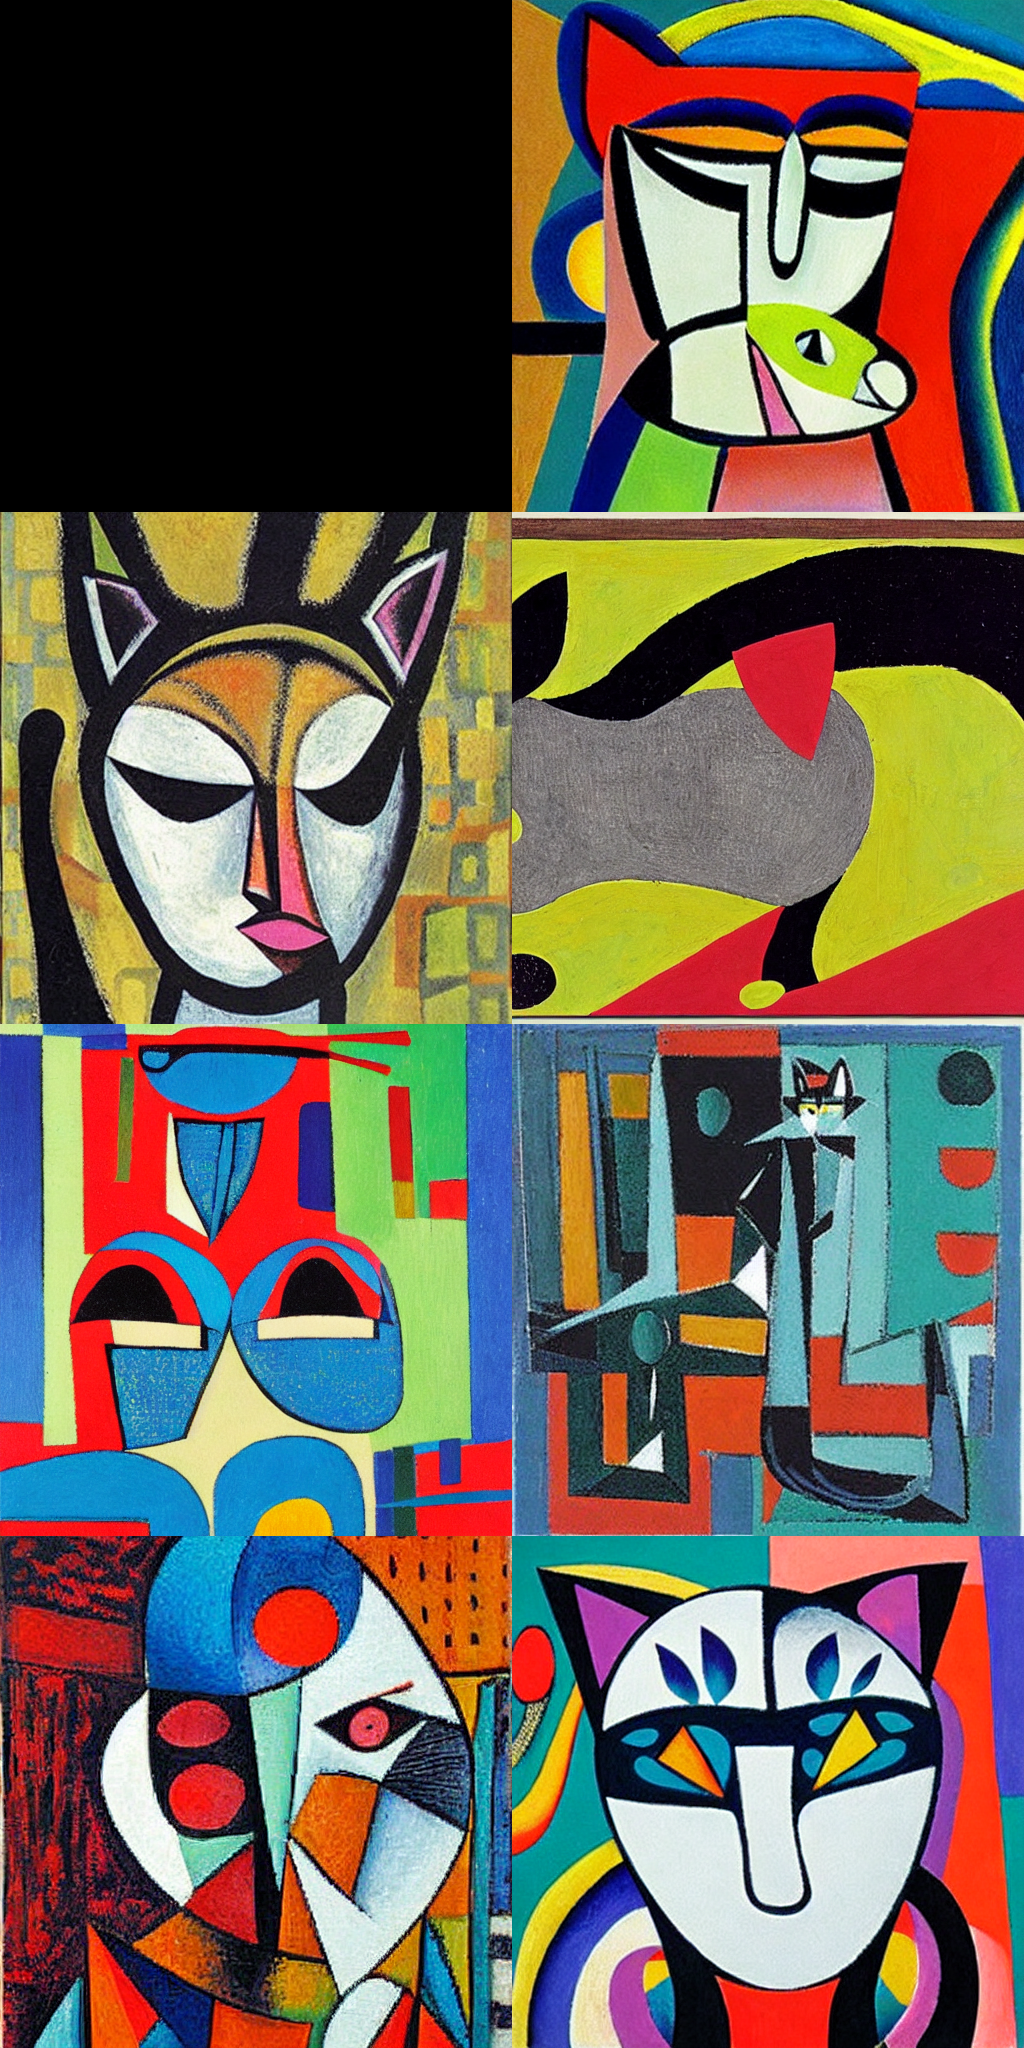

In [416]:
from diffusers.utils import make_image_grid
make_image_grid(images, rows=4, cols=2)